Maximize the cost function below. 
$$𝐂(𝐳) = 3𝑧_1 𝑧_2 − 𝑧_2 𝑧_3$$

In [18]:
from qiskit import *
from qiskit.circuit import Parameter

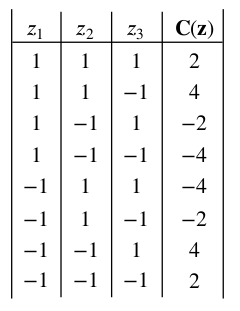

### Gamma circuit; Problem hamiltonian.


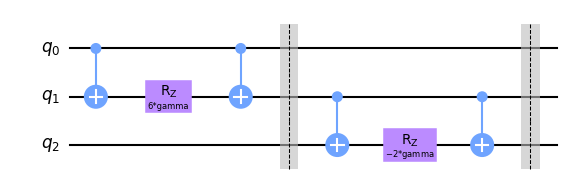

In [19]:
qc_gamma = QuantumCircuit(3)
gamma = Parameter('gamma')

for s,e in [[0,1]]:
    qc_gamma.cx(s,e)
    qc_gamma.rz(6*gamma, e)
    qc_gamma.cx(s,e)
    qc_gamma.barrier()

for s,e in [[1,2]]:
    qc_gamma.cx(s,e)
    qc_gamma.rz(-2*gamma, e)
    qc_gamma.cx(s,e)
    qc_gamma.barrier()    

qc_gamma.draw(fold=1000, output="mpl", scale=0.75)


### Mixer hamiltonian

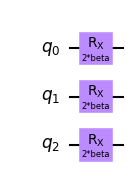

In [20]:
qc_mixer = QuantumCircuit(3)
beta = Parameter('beta')

for i in range(3):
    qc_mixer.rx(2*beta, i)

qc_mixer.draw(fold=1000, output="mpl", scale=0.75)



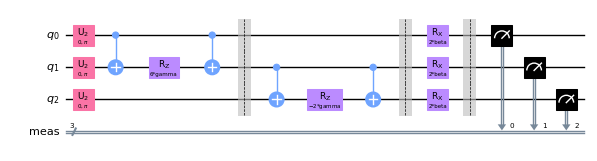

In [21]:
QC = QuantumCircuit(3)

for i in range(3):
    QC.h(i)

QC.append(qc_gamma, [0,1,2])
QC.append(qc_mixer, [0,1,2])
QC.measure_all()

QC = QC.decompose()

tqc = transpile(QC, backend=Aer.get_backend('aer_simulator'))

QC.draw(output="mpl", scale=0.5, fold=1000)


The objective of the function below is to take a specific solution and revert its solution to negative number to rhyme with the minimizer. 

In [22]:
def maxcut_obj(solution):
    a=-1
    b=-1
    c=-1

    if solution[0] == '0':
        a = 1 
    if solution[1] == '0':
        b = 1 
    if solution[2] == '0':
        c = 1
    return 0-(3*a*b-b*c)

def compute_expectation(counts):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [23]:
def quantum_circuit():
    backend=Aer.get_backend('aer_simulator')

    def circuit_run(parameters):
        g, b = parameters
        a = assemble(tqc, backend=backend, shots=1,parameter_binds=[{beta: b, gamma: g}])
        counts = backend.run(a, shots=1000).result().get_counts() 
        return compute_expectation(counts)
    return circuit_run

In [24]:
from scipy.optimize import minimize
expectation = quantum_circuit()
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res

/var/folders/n5/sr7wwb8n1wggd7jsk_k37l_w0000gn/T/ipykernel_12855/2645700161.py:7: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  counts = backend.run(a, shots=1000).result().get_counts()


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.554
       x: [ 9.759e-01  1.162e+00]
    nfev: 31
   maxcv: 0.0

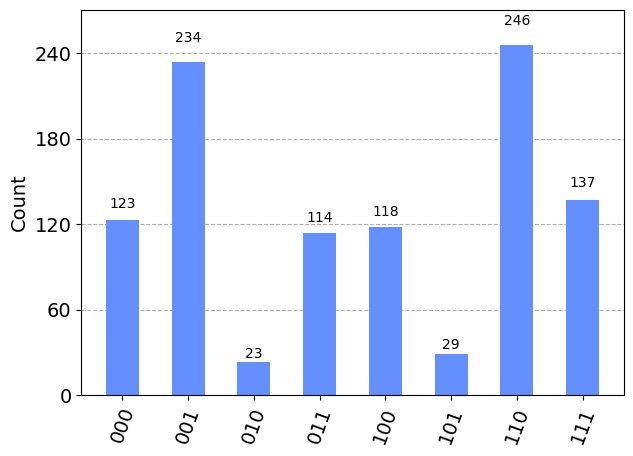

In [25]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram
a = tqc.bind_parameters({beta: res.x[0], gamma: res.x[1]})
counts = backend.run(a, seed_simulator=10).result().get_counts()
plot_histogram(counts)

001 and 110 produce the maximum of 4.